In [1]:
import numpy as np
import pandas as pd
import math
import os
import datetime

from DP_LSTM import *
from keras.models import load_model
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from Plot_Self_Correlation import plot_auto_corr

from matplotlib import pyplot as plt

A:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def walkfiles(rootdir): # 返回file路径的list
    flist = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    pathContainer = []
    filenameContainer = []
    for i in range(0,len(flist)):
        path = os.path.join(rootdir,flist[i])
        if os.path.isfile(path):
            pathContainer.append(path)
            filenameContainer.append(flist[i])
    return pathContainer,filenameContainer

rootdir = 'D:\WORK__wells\GraduateProgram\Data\TimeSeries'
pathContainer,filenameContainer = walkfiles(rootdir)

In [3]:
#首先对一种货币进行短期预测实验

'''
['D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\AUDUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\EURUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\GBPUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDCAD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDCHF.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\TimeSeries\\USDJPY.csv']
'''
# 第i个文件
i = 1
ExgRate_pd = pd.read_csv(pathContainer[i])
ExgRate_pd['DateTime'] = pd.to_datetime(ExgRate_pd.DateTime)

In [4]:
preTrained_pd = ExgRate_pd.loc[ExgRate_pd.DateTime < '2017']
preTrained_pd.index = [i for i in range(preTrained_pd.shape[0])]
data_pd = ExgRate_pd.loc[ExgRate_pd.DateTime > '2017']
data_pd.index = [i for i in range(data_pd.shape[0])]

In [5]:
'''看是否有缺失情况'''

# data_dic = {'DateTime':[],'value':[]}
# datetime = preTrained_pd.DateTime.get_values()
# exchangeRate = preTrained_pd.DateTime.get_values()
# for i in range(1,preTrained_pd.shape[0]):
#     data_dic['DateTime'].append(datetime[i])
#     data_dic['value'].append(exchangeRate[i] - exchangeRate[i-1])
# new_pd = pd.DataFrame(data_dic)

'看是否有缺失情况'

In [6]:
'''数据处理模块'''
#对实验数据进行归一化处理
def GetTimeScale(data_pd, Time_scale):#根据给定的时间宽度构造数据
    result_dic = {'DateTime':[],'ExgRate':[]}
    for i in range(data_pd.shape[0]):
        if (i+1)%Time_scale == 0:
            new_grid_pd = data_pd.iloc[i,:]
            result_dic['DateTime'].append(new_grid_pd.DateTime)
            result_dic['ExgRate'].append(new_grid_pd.ExgRate)
    result_pd = pd.DataFrame(result_dic)
    return result_pd

# 计算 log收益率 *100
def GetProfit(TimeScale_pd):
    result_dic = {'DateTime':[],'ExgRate':[]}
    for i in range(1,TimeScale_pd.shape[0]):
        local_pd = TimeScale_pd.iloc[i,:]
        pre_pd = TimeScale_pd.iloc[i-1,:]
        result_dic['DateTime'].append(local_pd.DateTime)
        result_dic['ExgRate'].append(1000*(math.log(local_pd.ExgRate) - math.log(pre_pd.ExgRate)))
    result_pd = pd.DataFrame(result_dic)
    return result_pd

def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    Raw_pd_empty = Raw_pd.loc[Raw_pd.ExgRate.isna()]
    Raw_pd_Nonempty = Raw_pd.drop(Raw_pd_empty.index,axis=0)
    MMScaler = MinMaxScaler(feature_range=(1,2))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd_Nonempty['ExgRate'].get_values(),(Raw_pd_Nonempty.ExgRate.shape[0],1)))
    Raw_pd_Nonempty['ExgRate'] = MMScaled_Data
    Raw_pd = pd.concat([Raw_pd_Nonempty, Raw_pd_empty])
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length):
        result.append(Normalized_pd.ExgRate[index: index + sequence_length])
    result = np.array(result)
    return result

In [7]:
def PrePareLSTM(ExgRate_pd,params):
    print(r'预训练模型')
    Base_pd = ExgRate_pd.copy()
    Base_pd,BaseMMScaler = Raw_Data_Normalized(Base_pd)
    TimeSeries = GetTimeSeriesData(Base_pd, params['TimeLag'])
    PretrainSeries_X = TimeSeries[:,:-1]
    PretrainSeries_Y = TimeSeries[:,-1]
    # 张量化
    PretrainSeries_X = np.reshape(PretrainSeries_X, (PretrainSeries_X.shape[0], 1,PretrainSeries_X.shape[1]))
    PretrainSeries_Y = np.reshape(PretrainSeries_Y, (PretrainSeries_Y.shape[0], 1,1))
    #预先训练基本模型
    pre_Model = build_LSTM_Model(inputDim = PretrainSeries_X.shape[2],lr=params['lr'],
                                 nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_pre_model = model_fit(pre_Model,PretrainSeries_X, PretrainSeries_Y, 
                                 validation_split=0.2, epochs=100, 
                                 batch_size=params['batch_size'])
    print(r'预训练模型学习完毕！') 
    return Fitted_pre_model

In [8]:
def FineTune(Prepared_model, Train_X, Train_Y,params):
    from keras.layers import Dense
    model_new = Prepared_model
    model_new.pop()
    for i in range(len(Prepared_model.layers)-1):  # 除最后一层外，权重全部导入
        model_new.layers[i].set_weights(Prepared_model.layers[i].get_weights())
        if i < params['frozenlayer']:
            model_new.layers[i].trainable=False
    
        # model_new.add(Dense(5, activation='sigmoid', name='last2'))
    model_new.add(Dense(1,use_bias = True,activation='linear'))
#     saveFile = 'D:/CPQ/air/hour_tranfer_hour'
    #调整迁移预测数据准备
    # 标准化进行预测
    print('微调迁移学习模型')
    Prepared_model = model_fit(model_new, Train_X, 
                                   Train_Y,epochs=params['TransferEpochs'], 
                                   batch_size=params['TransferBatch_size'])
    return Prepared_model

In [9]:
# 短期预测
'''
输入：DataFrame， 参数params
输出： 与BP神经网络、支持向量回归和时间序列模型进行比较得到的各项指标与预测的值DateFrame
'''


def TransferLearning(ExgRate_pd, PrepareModel,params):
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    line_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    # 对数据进行预处理
    scaleddata_pd = GetTimeScale(ExgRate_pd, params['Timescale'])
    
    Raw_pd,MMScaler = Raw_Data_Normalized(scaleddata_pd)
    print(r'处理数据:',Raw_pd.shape)
    # 构造时间序列数据
    TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
    # 划分训练测试集
    TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
    print(r'训练数据:',TrainSeries.shape)
    TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
    print(r'验证数据:',TestSeries.shape)
    TrainSeries_X = TrainSeries[:,:-1]
    TrainSeries_Y = TrainSeries[:,-1]
    TestSeries_X = TestSeries[:,:-1]
    TestSeries_Y = TestSeries[:,-1]
    # 张量化
    Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
    Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
    Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
    Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
    
    print(r'LSTM预测')
    
    LSTM_Model = build_LSTM_Model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_model = model_fit(LSTM_Model,Train_X, Train_Y, validation_split=0.2, epochs=params['epochs'], batch_size=params['batch_size'])
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
    line_pd['RMSE'] = [RMSE]
    line_pd['MAE'] = [MAE]
    line_pd['MAPE'] = [MAPE]
    line_pd['TimeLags'] = [params['TimeLag']]
    
    print(r'迁移学习微调')
    Prepared_model = FineTune(PrepareModel, Train_X, Train_Y,params)
    print(r'迁移学习LSTM预测')
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Prepared_model,Test_X,Test_Y,MMScaler)
    
    result_pd = pd.concat([result_pd, line_pd])
    result_pd.to_csv(r'D:\WORK__wells\GraduateProgram\Result\直接预测结果.csv',index=None)
    return result_pd

In [10]:
'''
判断是否随着时间跨度的延长，LSTM模型的预测效果会越来越差
输入preTrained_pd，param(其中timelag是list)
输出不同时滞下的预测指标
'''
def PreTest(preTrained_pd, params):
    result_pd = pd.DataFrame(columns=['Timescale','RMSE','MAE','MAPE'])
    line_pd = pd.DataFrame(columns=['Timescale','RMSE','MAE','MAPE'])
    for eachTimescale in params['Timescale']:
        # 对数据进行预处理
        scaleddata_pd = GetTimeScale(ExgRate_pd, eachTimescale)
        scaleddata_pd = GetProfit(scaleddata_pd)
        Raw_pd,MMScaler = Raw_Data_Normalized(scaleddata_pd)
        print(r'处理数据:',Raw_pd.shape)
        # 构造时间序列数据
        TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
        # 划分训练测试集
        TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
        print(r'训练数据:',TrainSeries.shape)
        TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
        print(r'验证数据:',TestSeries.shape)
        TrainSeries_X = TrainSeries[:,:-1]
        TrainSeries_Y = TrainSeries[:,-1]
        TestSeries_X = TestSeries[:,:-1]
        TestSeries_Y = TestSeries[:,-1]
        # 张量化
        Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
        Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
        Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
        Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
        print(r'LSTM预测,时间粒度:%s'%eachTimescale)
    
        LSTM_Model = build_LSTM_Model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
        Fitted_model = model_fit(LSTM_Model,Train_X, Train_Y, validation_split=0.2, epochs=params['epochs'], batch_size=params['batch_size'])
        RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
        line_pd['RMSE'] = [RMSE]
        line_pd['MAE'] = [MAE]
        line_pd['MAPE'] = [MAPE]
        line_pd['Timescale'] = [eachTimescale]
        result_pd = pd.concat([result_pd, line_pd])
    return result_pd

处理数据: (1771, 2)
训练数据: (1232, 11)
验证数据: (528, 11)
LSTM预测,时间粒度:420
Train on 985 samples, validate on 247 samples
Epoch 1/500
985/985 [==============================] - 4s 4ms/step - loss: 2.4827 - mean_absolute_error: 1.5739 - mean_absolute_percentage_error: 99.8807 - val_loss: 2.4933 - val_mean_absolute_error: 1.5779 - val_mean_absolute_percentage_error: 99.7310
Epoch 2/500
985/985 [==============================] - 0s 178us/step - loss: 2.4691 - mean_absolute_error: 1.5696 - mean_absolute_percentage_error: 99.6054 - val_loss: 2.4792 - val_mean_absolute_error: 1.5734 - val_mean_absolute_percentage_error: 99.4485
Epoch 3/500
985/985 [==============================] - 0s 161us/step - loss: 2.4546 - mean_absolute_error: 1.5650 - mean_absolute_percentage_error: 99.3115 - val_loss: 2.4639 - val_mean_absolute_error: 1.5685 - val_mean_absolute_percentage_error: 99.1407
Epoch 4/500
985/985 [==============================] - 0s 161us/step - loss: 2.4387 - mean_absolute_error: 1.5599 - mean_absol

Epoch 33/500
985/985 [==============================] - 0s 170us/step - loss: 0.0064 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 3.5618 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 2.9940
Epoch 34/500
985/985 [==============================] - 0s 162us/step - loss: 0.0064 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 3.5617 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 2.9933
Epoch 35/500
985/985 [==============================] - 0s 167us/step - loss: 0.0064 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 3.5615 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 2.9927
Epoch 36/500
985/985 [==============================] - 0s 176us/step - loss: 0.0064 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 3.5613 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentag

985/985 [==============================] - 0s 171us/step - loss: 0.0064 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 3.5461 - val_loss: 0.0044 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 2.9791
Epoch 98/500
985/985 [==============================] - 0s 155us/step - loss: 0.0064 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 3.5458 - val_loss: 0.0044 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 2.9788
Epoch 99/500
985/985 [==============================] - 0s 152us/step - loss: 0.0064 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 3.5455 - val_loss: 0.0044 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 2.9785
Epoch 100/500
985/985 [==============================] - 0s 156us/step - loss: 0.0064 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 3.5451 - val_loss: 0.0044 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 2.9

Epoch 161/500
985/985 [==============================] - 0s 162us/step - loss: 0.0063 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 3.5214 - val_loss: 0.0043 - val_mean_absolute_error: 0.0473 - val_mean_absolute_percentage_error: 2.9566
Epoch 162/500
985/985 [==============================] - 0s 142us/step - loss: 0.0063 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 3.5210 - val_loss: 0.0043 - val_mean_absolute_error: 0.0473 - val_mean_absolute_percentage_error: 2.9562
Epoch 163/500
985/985 [==============================] - 0s 170us/step - loss: 0.0063 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 3.5205 - val_loss: 0.0043 - val_mean_absolute_error: 0.0472 - val_mean_absolute_percentage_error: 2.9558
Epoch 164/500
985/985 [==============================] - 0s 152us/step - loss: 0.0063 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 3.5201 - val_loss: 0.0043 - val_mean_absolute_error: 0.0472 - val_mean_absolute_perce

Epoch 193/500
985/985 [==============================] - 0s 159us/step - loss: 0.0063 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 3.5059 - val_loss: 0.0043 - val_mean_absolute_error: 0.0470 - val_mean_absolute_percentage_error: 2.9423
Epoch 194/500
985/985 [==============================] - 0s 173us/step - loss: 0.0063 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 3.5053 - val_loss: 0.0043 - val_mean_absolute_error: 0.0470 - val_mean_absolute_percentage_error: 2.9418
Epoch 195/500
985/985 [==============================] - 0s 157us/step - loss: 0.0063 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 3.5048 - val_loss: 0.0043 - val_mean_absolute_error: 0.0470 - val_mean_absolute_percentage_error: 2.9413
Epoch 196/500
985/985 [==============================] - 0s 153us/step - loss: 0.0063 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 3.5043 - val_loss: 0.0043 - val_mean_absolute_error: 0.0470 - val_mean_absolute_perce

985/985 [==============================] - 0s 131us/step - loss: 0.0062 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 3.4695 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 2.9075
Epoch 258/500
985/985 [==============================] - 0s 143us/step - loss: 0.0062 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 3.4689 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 2.9069
Epoch 259/500
985/985 [==============================] - 0s 148us/step - loss: 0.0062 - mean_absolute_error: 0.0539 - mean_absolute_percentage_error: 3.4683 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 2.9063
Epoch 260/500
985/985 [==============================] - 0s 173us/step - loss: 0.0062 - mean_absolute_error: 0.0539 - mean_absolute_percentage_error: 3.4676 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 2

985/985 [==============================] - 0s 142us/step - loss: 0.0061 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 3.4279 - val_loss: 0.0041 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 2.8651
Epoch 322/500
985/985 [==============================] - 0s 138us/step - loss: 0.0061 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 3.4272 - val_loss: 0.0041 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 2.8644
Epoch 323/500
985/985 [==============================] - 0s 142us/step - loss: 0.0061 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 3.4265 - val_loss: 0.0041 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 2.8637
Epoch 324/500
985/985 [==============================] - 0s 162us/step - loss: 0.0061 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 3.4258 - val_loss: 0.0041 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 2

985/985 [==============================] - 0s 143us/step - loss: 0.0060 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 3.3816 - val_loss: 0.0041 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 2.8163
Epoch 386/500
985/985 [==============================] - 0s 138us/step - loss: 0.0060 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 3.3809 - val_loss: 0.0041 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 2.8155
Epoch 387/500
985/985 [==============================] - 0s 139us/step - loss: 0.0060 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 3.3801 - val_loss: 0.0041 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 2.8147
Epoch 388/500
985/985 [==============================] - 0s 132us/step - loss: 0.0059 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 3.3794 - val_loss: 0.0041 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 2

985/985 [==============================] - 0s 135us/step - loss: 0.0058 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 3.3367 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 2.7637
Epoch 450/500
985/985 [==============================] - 0s 142us/step - loss: 0.0058 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 3.3361 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 2.7629
Epoch 451/500
985/985 [==============================] - 0s 151us/step - loss: 0.0058 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 3.3354 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 2.7620
Epoch 452/500
985/985 [==============================] - 0s 154us/step - loss: 0.0058 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 3.3347 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 2

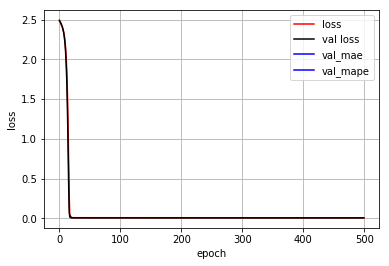

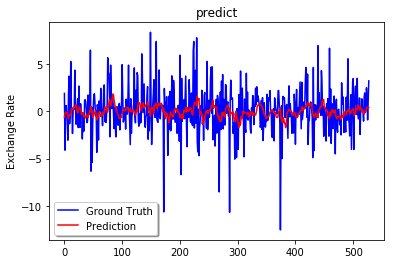

RMSE:2.4538115623807584  ,MAE:1.7725323807591942  ,MAPE:155.3521797505438 
处理数据: (1549, 2)
训练数据: (1077, 11)
验证数据: (461, 11)
LSTM预测,时间粒度:480
Train on 861 samples, validate on 216 samples
Epoch 1/500
861/861 [==============================] - 5s 6ms/step - loss: 2.2083 - mean_absolute_error: 1.4832 - mean_absolute_percentage_error: 99.8978 - val_loss: 2.2257 - val_mean_absolute_error: 1.4897 - val_mean_absolute_percentage_error: 99.7612
Epoch 2/500
861/861 [==============================] - 0s 185us/step - loss: 2.1976 - mean_absolute_error: 1.4796 - mean_absolute_percentage_error: 99.6534 - val_loss: 2.2146 - val_mean_absolute_error: 1.4860 - val_mean_absolute_percentage_error: 99.5104
Epoch 3/500
861/861 [==============================] - 0s 188us/step - loss: 2.1863 - mean_absolute_error: 1.4757 - mean_absolute_percentage_error: 99.3938 - val_loss: 2.2027 - val_mean_absolute_error: 1.4820 - val_mean_absolute_percentage_error: 99.2409
Epoch 4/500
861/861 [==============================

861/861 [==============================] - 0s 184us/step - loss: 0.0100 - mean_absolute_error: 0.0723 - mean_absolute_percentage_error: 4.9544 - val_loss: 0.0075 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 4.1489
Epoch 65/500
861/861 [==============================] - 0s 187us/step - loss: 0.0100 - mean_absolute_error: 0.0723 - mean_absolute_percentage_error: 4.9540 - val_loss: 0.0075 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 4.1486
Epoch 66/500
861/861 [==============================] - 0s 187us/step - loss: 0.0100 - mean_absolute_error: 0.0723 - mean_absolute_percentage_error: 4.9535 - val_loss: 0.0075 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 4.1482
Epoch 67/500
861/861 [==============================] - 0s 184us/step - loss: 0.0100 - mean_absolute_error: 0.0723 - mean_absolute_percentage_error: 4.9531 - val_loss: 0.0075 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 4.14

861/861 [==============================] - 0s 154us/step - loss: 0.0099 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 4.9193 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 4.1202
Epoch 128/500
861/861 [==============================] - 0s 172us/step - loss: 0.0099 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 4.9186 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 4.1197
Epoch 129/500
861/861 [==============================] - 0s 193us/step - loss: 0.0099 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 4.9180 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 4.1191
Epoch 130/500
861/861 [==============================] - 0s 153us/step - loss: 0.0099 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 4.9173 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 4

861/861 [==============================] - 0s 172us/step - loss: 0.0098 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 4.8718 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 4.0792
Epoch 192/500
861/861 [==============================] - 0s 192us/step - loss: 0.0098 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 4.8710 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 4.0785
Epoch 193/500
861/861 [==============================] - 0s 204us/step - loss: 0.0098 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 4.8701 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 4.0778
Epoch 194/500
861/861 [==============================] - 0s 166us/step - loss: 0.0097 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 4.8693 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 4

861/861 [==============================] - 0s 166us/step - loss: 0.0096 - mean_absolute_error: 0.0703 - mean_absolute_percentage_error: 4.8157 - val_loss: 0.0072 - val_mean_absolute_error: 0.0608 - val_mean_absolute_percentage_error: 4.0313
Epoch 256/500
861/861 [==============================] - 0s 146us/step - loss: 0.0096 - mean_absolute_error: 0.0703 - mean_absolute_percentage_error: 4.8148 - val_loss: 0.0072 - val_mean_absolute_error: 0.0608 - val_mean_absolute_percentage_error: 4.0305
Epoch 257/500
861/861 [==============================] - 0s 163us/step - loss: 0.0096 - mean_absolute_error: 0.0703 - mean_absolute_percentage_error: 4.8138 - val_loss: 0.0072 - val_mean_absolute_error: 0.0608 - val_mean_absolute_percentage_error: 4.0297
Epoch 258/500
861/861 [==============================] - 0s 170us/step - loss: 0.0096 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 4.8129 - val_loss: 0.0072 - val_mean_absolute_error: 0.0608 - val_mean_absolute_percentage_error: 4

861/861 [==============================] - 0s 165us/step - loss: 0.0094 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 4.7537 - val_loss: 0.0071 - val_mean_absolute_error: 0.0601 - val_mean_absolute_percentage_error: 3.9817
Epoch 320/500
861/861 [==============================] - 0s 172us/step - loss: 0.0094 - mean_absolute_error: 0.0693 - mean_absolute_percentage_error: 4.7527 - val_loss: 0.0071 - val_mean_absolute_error: 0.0601 - val_mean_absolute_percentage_error: 3.9809
Epoch 321/500
861/861 [==============================] - 0s 156us/step - loss: 0.0094 - mean_absolute_error: 0.0693 - mean_absolute_percentage_error: 4.7517 - val_loss: 0.0071 - val_mean_absolute_error: 0.0600 - val_mean_absolute_percentage_error: 3.9801
Epoch 322/500
861/861 [==============================] - 0s 156us/step - loss: 0.0094 - mean_absolute_error: 0.0693 - mean_absolute_percentage_error: 4.7507 - val_loss: 0.0071 - val_mean_absolute_error: 0.0600 - val_mean_absolute_percentage_error: 3

861/861 [==============================] - 0s 185us/step - loss: 0.0092 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 4.6886 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 3.9288
Epoch 384/500
861/861 [==============================] - 0s 185us/step - loss: 0.0092 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 4.6875 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 3.9280
Epoch 385/500
861/861 [==============================] - 0s 190us/step - loss: 0.0092 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 4.6865 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 3.9271
Epoch 386/500
861/861 [==============================] - 0s 200us/step - loss: 0.0092 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 4.6855 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 3

861/861 [==============================] - 0s 168us/step - loss: 0.0091 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 4.6269 - val_loss: 0.0069 - val_mean_absolute_error: 0.0586 - val_mean_absolute_percentage_error: 3.8789
Epoch 448/500
861/861 [==============================] - 0s 161us/step - loss: 0.0091 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 4.6259 - val_loss: 0.0069 - val_mean_absolute_error: 0.0586 - val_mean_absolute_percentage_error: 3.8783
Epoch 449/500
861/861 [==============================] - 0s 151us/step - loss: 0.0091 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 4.6250 - val_loss: 0.0069 - val_mean_absolute_error: 0.0586 - val_mean_absolute_percentage_error: 3.8776
Epoch 450/500
861/861 [==============================] - 0s 188us/step - loss: 0.0091 - mean_absolute_error: 0.0674 - mean_absolute_percentage_error: 4.6241 - val_loss: 0.0069 - val_mean_absolute_error: 0.0586 - val_mean_absolute_percentage_error: 3

Epoch 479/500
861/861 [==============================] - 0s 160us/step - loss: 0.0090 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 4.5978 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 3.8570
Epoch 480/500
861/861 [==============================] - 0s 166us/step - loss: 0.0090 - mean_absolute_error: 0.0670 - mean_absolute_percentage_error: 4.5970 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 3.8563
Epoch 481/500
861/861 [==============================] - 0s 165us/step - loss: 0.0090 - mean_absolute_error: 0.0670 - mean_absolute_percentage_error: 4.5961 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 3.8556
Epoch 482/500
861/861 [==============================] - 0s 161us/step - loss: 0.0090 - mean_absolute_error: 0.0670 - mean_absolute_percentage_error: 4.5952 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583 - val_mean_absolute_perce

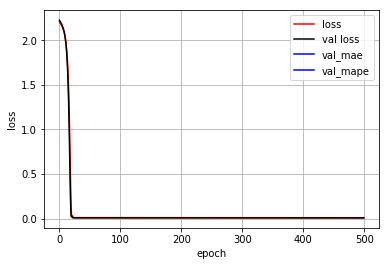

D:\WORK__wells\GraduateProgram\DP_LSTM.py:84: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


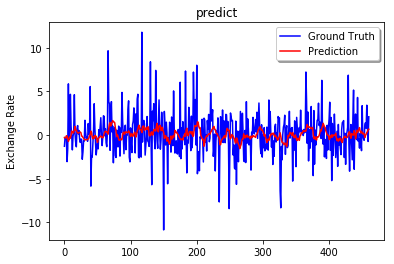

RMSE:2.5657756973323558  ,MAE:1.8840007876747704  ,MAPE:inf 


'\n迁移学习\n'

In [11]:
params = {
          'Timescale':[420,480],
          'lr': 0.0001,
          'nb_hidden_cell': [80,80,80,80,80],
          'epochs': 500,
          'batch_size': 100,
          'TimeLag': 10,
          'TrainTestSplit':0.7,
          
          'TransferEpochs':200,
          'TransferBatch_size':100,
          'frozenlayer':2}
'''
判断是否随着时间跨度的延长，LSTM模型的预测效果会越来越差
30,60,120,180,240,300,360,420,480
'''
result_pd = PreTest(preTrained_pd, params)

'''
预训练模型
'''
# prepared_pd = GetTimeScale(preTrained_pd, 60)
# model = PrePareLSTM(prepared_pd,params)
# saveFile = r'D:\WORK__wells\GraduateProgram\Model\preModel_1yearData1hourgrid.h5'
# model.save(saveFile)
'''
迁移学习
'''
# from keras.models import load_model
# model = load_model(r'D:\WORK__wells\GraduateProgram\Model\preModel_1yearData1hourgrid.h5')
# TimeSeries = TransferLearning(data_pd,model, params)

In [12]:
result_pd

,Timescale,RMSE,MAE,MAPE
0,420,2.453812,1.772532,155.352180
0,480,2.565776,1.884001,inf


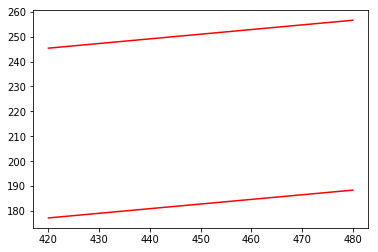

In [13]:
plt.plot(result_pd.Timescale,result_pd.RMSE*100,'r', label='Prediction')
plt.plot(result_pd.Timescale,result_pd.MAE*100,'r', label='Prediction')
# plt.plot(predict_array, 'r', label='Prediction')

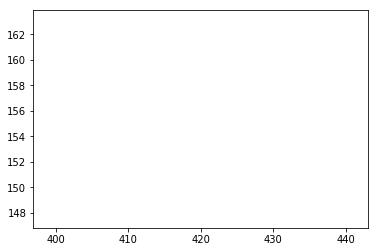

In [14]:
plt.plot(result_pd.Timescale,result_pd.MAPE,'r', label='Prediction')